In [12]:
import pandas as pd
import numpy as np
import operator

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
plt.style.use('ggplot')

### Create Item Profiles

This notebook creates a features vector for each item in the csv file. We then save this as a seperate csv file. For each user we create a user profile by loading all shows in the users likes and taking the average of all features. We then compute the cosine similarity between this and the item profiles to get similarities.

In [2]:
df = pd.read_csv('netflix_data.csv', index_col=0)
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...


## Feature Selection

In [3]:
def get_unique_values(col):
    """
    Splits each item in dataframe column and
    returns the unqiue values.
    args:
        col : Pandas DataFrame column
    """
    col = col.dropna()
    unique_values = set()
    for i, row in col.iteritems():
        values = [x.strip() for x in row.split(',') if x != '']
        unique_values.update(values)
    return list(unique_values)

In [4]:
# Get unique values for columns
categories = get_unique_values(df['listed_in'])
countries = get_unique_values(df['country'])
directors = get_unique_values(df['director'])

print(f'Number of categories {len(categories)}')
print(f'Number of countries {len(countries)}')
print(f'Number of directors {len(directors)}')

Number of categories 42
Number of countries 110
Number of directors 3655


There are a lot of directors in our dataset , we will check how many films each has directed. We can remove directors who only appear once as this will not affect the accuracy or our recommendations.

In [14]:
def get_count_dict(feature_list, col_name):
    feature_dict = {}
    for f in feature_list:
        feature_dict[f] = df[col_name].str.count(f).sum()
    
    sorted_dict = sorted(feature_dict.items(), key=operator.itemgetter(1), reverse=True)
    value_counts = [i[1] for i in sorted_dict]
    return sorted_dict, value_counts

In [15]:
director_dict, director_counts = get_count_dict(directors, 'director')

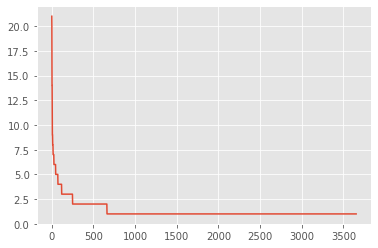

In [16]:
plt.plot(director_counts)
plt.show()

In [20]:
count1 = director_counts.count(1.0)
count2 = director_counts.count(2.0)

print(f'There are {len(directors)} in total.')
print(f'{count1} have only directed one show')
print(f'{count2} have only directed two shows')

There are 3655 in total.
2993 have only directed one show
413 have only directed two shows


We will remove directors who have directed two or less films. This should help reduce complexity and shouldn't affect the quality of our recommendations too much.

In [30]:
director_cols = [i[0] for i in director_dict if i[1] > 2]

In [23]:
# Check countries
country_dict, country_counts = get_count_dict(countries, 'country')

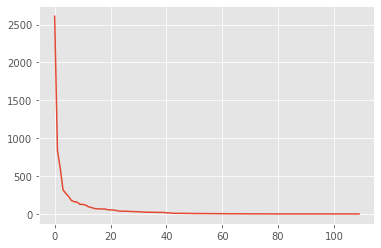

In [24]:
plt.plot(country_counts)
plt.show()

In [26]:
print(f'There are {len(countries)} countries in total.')
print(f'{country_counts.count(1.0)} countries only appear once.')

There are 110 countries in total.
33 countries only appear once.


In [27]:
# Remove countries that only appear once
country_cols = [i[0] for i in country_dict if i[1] > 1]

In [28]:
# Check year
min_year = df['release_year'].min()
max_year = df['release_year'].max()
year_dif = max_year - min_year

print(f'Min release year {min_year}, Max year {max_year}')
print(f'Difference: {year_dif}')

Min release year 1925, Max year 2020
Difference: 95


We will use category, director and country as binary features. For year we will scale the values to 0-1 by subtracting the minimum year and dividing by max-min, 95.

## Create Item Profiles DataFrame

In [31]:
cols = categories + country_cols + director_cols + ['year']
item_profiles = pd.DataFrame(index=range(df.shape[0]), columns=cols)
item_profiles.head()

,Docuseries,TV Shows,Reality TV,TV Thrillers,Comedies,TV Mysteries,LGBTQ Movies,Anime Series,Movies,TV Comedies,...,Hasan Karacadağ,Atom Egoyan,David Michôd,Phillip Noyce,Dante Lam,Steve Ball,Lasse Hallström,Bo Burnham,Raj Kumar Gupta,year
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# Add values to DataFrame
for i, row in df.iterrows():
    # Add category features
    for category in row['listed_in'].split(','):
        item_profiles[category.strip()][i] = 1
        
    # Checkfor NaNs and add country features
    if type(row['country']) == str:
        countries = set([i.strip() for i in row['country'].split(',') if i != ''])
        for country in countries:
            if country in country_cols:
                item_profiles[country][i] = 1
    
    # Add director features
    if type(row['director']) == str:
        dirs = set([i for i in row['director'].split(',')])
        for d in dirs:
            if d in director_cols:
                item_profiles[d][i] = 1

    # Scale year by subtracting minimum
    item_profiles.iloc[i]['year'] = row['release_year'] - min_year


In [33]:
# Drop NaNs and normalize year
item_profiles.fillna(0, inplace=True)
item_profiles['year'] = item_profiles['year'] / 95
item_profiles.head()

,Docuseries,TV Shows,Reality TV,TV Thrillers,Comedies,TV Mysteries,LGBTQ Movies,Anime Series,Movies,TV Comedies,...,Hasan Karacadağ,Atom Egoyan,David Michôd,Phillip Noyce,Dante Lam,Steve Ball,Lasse Hallström,Bo Burnham,Raj Kumar Gupta,year
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.989474
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.957895
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.926316
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.957895
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.968421


In [35]:
# Add title column and save
item_profiles['title'] = df['title']
item_profiles.to_csv('item_profiles.csv', index=False)

## Get recommendations using cosine similarity

In [36]:
def get_most_similar(item_profiles, user_profile, labels):
    """
    Uses Cos Theta to calculate similar items to  user profile
    
    args:
    item_profiles : pandas DataFrame of all item profiles
    user_profile : the users profile vector, the mean of all cols
    labels : Pandas Series show titles for labelling 
    """
    sim_df = pd.DataFrame(data=labels, columns=['title'])
    sim_df['similarity'] = cosine_similarity(item_profiles, user_profile)
    sim_df.sort_values(by=['similarity'], ascending=False, inplace=True)
    return sim_df

In [ ]:
labels = df['title']
item_profiles.drop(['title'], axis=1, inplace=True)

In [42]:
# Test using Norm of the North: King Sized Adventure
user_profile = item_profiles.iloc[0].values.reshape(1, -1)
most_sim = get_most_similar(item_profiles, user_profile, labels)
most_sim.head(20)

,title,similarity
0,Norm of the North: King Sized Adventure,1.000000
4963,Invader Zim: Enter the Florpus,0.770783
2905,Duck Duck Goose,0.770507
1210,Hey Arnold! The Jungle Movie,0.770218
3516,Garfield's Pet Force,0.767423
3515,Garfield's Fun Fest,0.767012
3753,Kevin Hart's Guide to Black History,0.755078
1355,Christmas Break-In,0.755078
4365,John Mulaney & The Sack Lunch Bunch,0.755078
1780,Norm of the North: Keys to the Kingdom,0.755078


In [43]:
def get_show_details(similarities, n=10):
    """
    Takes the similarities from get_most_silmilar
    and shows detail for first n
    """
    old_df = pd.read_csv('data.csv')
    for title in similarities['title'].values[:n]:
        row = old_df.loc[old_df['title'] == title]
        desc = row['description'].values[0]
        director = row['director'].values[0]
        country = row['country'].values[0]
        listed_in = row['listed_in'].values[0]
        year = row['release_year'].values[0]
        print(f'{i+1}: {title}: {desc}')
        print('Director: ', director)
        print('Country: ', country)
        print('Listed in: ', listed_in)
        print('Year: ', year, '\n')

In [44]:
get_show_details(most_sim)

6234: Norm of the North: King Sized Adventure: Before planning an awesome wedding for his grandfather, a polar bear king must take back a stolen artifact from an evil archaeologist first.
Director:  Richard Finn, Tim Maltby
Country:  United States, India, South Korea, China
Listed in:  Children & Family Movies, Comedies
Year:  2019 

6234: Invader Zim: Enter the Florpus: When Zim reappears to begin the next phase of his evil alien plan to conquer Earth, his nemesis Dib Membrane sets out to unmask him once and for all.
Director:  nan
Country:  South Korea, United States
Listed in:  Children & Family Movies, Comedies, Sci-Fi & Fantasy
Year:  2019 

6234: Duck Duck Goose: As his flock's annual migration nears, a carefree goose is grounded with an injury and takes a pair of lost ducklings under his wing.
Director:  Chris Jenkins
Country:  China, United States, United Kingdom
Listed in:  Children & Family Movies, Comedies
Year:  2018 

6234: Hey Arnold! The Jungle Movie: When Arnold and his